In [3]:
from tqdm import tqdm
from dotenv import load_dotenv 
load_dotenv()

from fourlang.text_to_4lang import TextTo4lang
from graphviz import Source
from scripts.parse_data import read_sherliic, build_graph

text_to_4lang = TextTo4lang(lang="en")
data = read_sherliic("data/dev.csv", ud_path="data/relation_index.tsv", keep_context=True)
data_frame = build_graph(data)

2020-12-08 08:00:52 INFO: Downloading default packages for language: en (English)...
INFO:stanza:Downloading default packages for language: en (English)...
2020-12-08 08:00:53 INFO: File exists: /home/adaamko/stanza_resources/en/default.zip.
INFO:stanza:File exists: /home/adaamko/stanza_resources/en/default.zip.
2020-12-08 08:01:01 INFO: Finished downloading models and saved to /home/adaamko/stanza_resources.
INFO:stanza:Finished downloading models and saved to /home/adaamko/stanza_resources.
2020-12-08 08:01:01 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| sentiment | sstplus   |
| ner       | ontonotes |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
|

In [4]:
data["prem_end"] = data["prem_end"].fillna('')
data["hypo_end"] = data["hypo_end"].fillna('')
data['premise_text'] = data["prem_argleft"] + " " + data["premise"].apply(lambda x: x.strip()) + " " + data["prem_argright"] + data["prem_end"]
data['hyp_text'] = data["hypo_argleft"] + " " + data["hypothesis"].apply(lambda x: x.strip()) + " " + data["hypo_argright"] + data["hypo_end"]

## ID-s where we found the entailment

In [5]:
import math
import re
import copy
from networkx import algorithms

import networkx as nx
from networkx import algorithms
import copy

"""
def whitelisting(graph, from_node):
    whitelist = []
    zero_graph = copy.deepcopy(graph)
    delete_list = []
    for edge in zero_graph.G.adj.items():
        for output_node in edge[1].items():
            inner_delete_list = []
            for edge_type in output_node[1].items():
                if edge_type[1]["color"] == 1 or edge_type[1]["color"] == 2:
                    inner_delete_list.append(edge_type[0])
            for inner_del in inner_delete_list:
                del output_node[1]._atlas[inner_del]
            if len(output_node[1]) < 1:
                delete_list.append(output_node[0])
        for to_del in delete_list:
            if to_del in edge[1]._atlas:
                del edge[1]._atlas[to_del]

    for node in zero_graph.G.nodes():
        if algorithms.has_path(zero_graph.G, from_node, node):
            if node != from_node:
                whitelist.append(node)

    return whitelist
"""

def whitelisting(graph, from_node):
    whitelist = []
    zero_graph = nx.MultiDiGraph()
    zero_graph.add_node(from_node)
    delete_list = []
    for edge in graph.G.edges(data=True):
        if not edge[2]["color"]:
            zero_graph.add_edge(edge[0], edge[1])
            

    for node in zero_graph.nodes():
        if algorithms.has_path(zero_graph, from_node, node):
            if node != from_node:
                whitelist.append(node)

    return whitelist


def blacklisting(graph):
    one_two_blacklist = ["A", "a", "b", "B"]
    for adj in graph.G._adj.values():
        #print(adj)
        for a in adj.items():
            #print(f"adj: {a[1]}")
            if {'color': 2} in a[1].values():
                new_blacklist_item = a[0]
                for node in graph.G.nodes:
                    if algorithms.has_path(graph.G, new_blacklist_item, node):
                        blacklist_node = graph.d_clean(node)
                        if blacklist_node != graph.root:
                            one_two_blacklist.append(
                                blacklist_node.split('_')[0])
                new_blacklist_item = graph.d_clean(new_blacklist_item)
                if new_blacklist_item != graph.root:
                    one_two_blacklist.append(
                        new_blacklist_item.split('_')[0])
    return one_two_blacklist


def append_zero_paths(graph):
    graph_to_return = copy.deepcopy(graph)
    edges = []
    for edge in graph.G.edges(data=True):
        X = edge[0]
        Y = edge[1]
        color = edge[2]['color']

        nodes_to_append = whitelisting(graph, Y)

        for node in nodes_to_append:
            edges.append((X, node, color))
            
        nodes_to_append = whitelisting(graph, X) 
        parent_edges = graph.G.edges(X, data=True)

        for node in nodes_to_append:
            node_edges = graph.G.edges(node, data=True)
            
            for n in parent_edges:
                n_color = n[2]["color"]
                edges.append((node, n[1], n_color))
            
            for n in node_edges:
                n_color = n[2]["color"]
                edges.append((X, n[1], n_color))
                
            parent_edges = graph.G.edges(X, data=True)

    edges = list(set(edges))
    for edge in edges:
        graph_to_return.G.add_edge(edge[0], edge[1], color=edge[2])
        
    return graph_to_return

In [6]:
import re
def clear_node(node):
    """
    Clears the node from the 4lang id parts
    :param node: the text to clear
    :return: the cleared text
    """
    node = re.sub(r'_[0-9][0-9]*', '', node)
    #if node in stopwords:
    #    node = "STOPWORD"
    return node

In [7]:
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words("english"))

def asim_jac_nodes(graph_premise, graph_hypothesis):
    """
    Asymmetric Jaccard similarity between the nodes of the definition graphs
    :param graph_premise: the definition graph of the premise
    :param graph_hypothesis: the definition graph of the hypothesis
    :return: the ratio of overlapping nodes per the length of the hypothesis definition
    """
    prem = set([clear_node(node) for node in graph_premise.G.nodes])
    hyp = set([clear_node(node) for node in graph_hypothesis.G.nodes])
        
    prem_cleared = [node for node in prem if node not in {"A", "B"}.union(stopwords)]
    hyp_cleared = [node for node in hyp if node not in {"A", "B"}.union(stopwords)]
    
    prem = set(prem_cleared)
    hyp = set(hyp_cleared)
    
    #print(prem)
    #print(hyp)
    
    sim = hyp & prem
    print(sim)
    if not sim or len(hyp) == 0:
        return 0
    else:
        return float(len(sim)) / len(hyp)
    
import math

def asim_jac_edges_all(graph_premise, graph_hypothesises):
    """
    Asymmetric Jaccard similarity between the edges of the definition graphs
    :param graph_premise: the definition graph of the premise
    :param graph_hypothesis: the definition graph of the hypothesis
    :return: the ratio of overlapping edges per the length of the hypothesis definition
    """
    sims = []
    
    prem = set([(clear_node(s), clear_node(r), e['color'])
                for (s, r, e) in graph_premise.G.edges(data=True)])
    
    for graph_hypothesis in graph_hypothesises:
        hyp = set([(clear_node(s), clear_node(r), e['color'])
                   for (s, r, e) in graph_hypothesis.G.edges(data=True)])
        """
        hyp_cleared = []
        for triplet in hyp:
            if triplet[0].upper() != "A" and  triplet[0].upper() != "B" and triplet[1].upper() != "A" and triplet[1].upper() != "B":
                hyp_cleared.append(triplet)


        hyp = set(hyp_cleared)
        """
        sim = hyp & prem
        print(sim)
        print(float(len(sim)) / len(hyp))
        if not sim or len(hyp) == 0:
            sims.append(0)
        else:
            #return float(len(sim)) / math.sqrt(len(hyp))
            #return len(sim)
            sims.append(float(len(sim)) / len(hyp))
            
    return max(sims)

def asim_jac_edges(graph_premise, graph_hypothesis):
    """
    Asymmetric Jaccard similarity between the edges of the definition graphs
    :param graph_premise: the definition graph of the premise
    :param graph_hypothesis: the definition graph of the hypothesis
    :return: the ratio of overlapping edges per the length of the hypothesis definition
    """
    prem = set([(clear_node(s), clear_node(r), e['color'])
                for (s, r, e) in graph_premise.G.edges(data=True)])
    hyp = set([(clear_node(s), clear_node(r), e['color'])
               for (s, r, e) in graph_hypothesis.G.edges(data=True)])
    """
    hyp_cleared = []
    for triplet in hyp:
        if triplet[0].upper() != "A" and  triplet[0].upper() != "B" and triplet[1].upper() != "A" and triplet[1].upper() != "B":
            hyp_cleared.append(triplet)

            
    hyp = set(hyp_cleared)
    """
    sim = hyp & prem
    #print(sim)
    if not sim or len(hyp) == 0:
        return 0
    else:
        #return float(len(sim)) / math.sqrt(len(hyp))
        #return len(sim)
        return float(len(sim)) / len(hyp)

In [6]:
[i for i, sample in enumerate(data.score.tolist()) if sample == 1]

[0,
 6,
 7,
 11,
 21,
 22,
 29,
 30,
 31,
 37,
 38,
 39,
 44,
 45,
 46,
 47,
 57,
 59,
 60,
 61,
 64,
 65,
 66,
 67,
 68,
 70,
 72,
 75,
 76,
 79,
 82,
 83,
 85,
 86,
 89,
 90,
 94,
 95,
 99,
 101,
 105,
 106,
 115,
 117,
 119,
 123,
 124,
 125,
 126,
 127,
 132,
 133,
 134,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 150,
 152,
 154,
 158,
 159,
 162,
 163,
 164,
 167,
 178,
 179,
 180,
 183,
 185,
 187,
 190,
 191,
 192,
 198,
 200,
 202,
 206,
 207,
 213,
 215,
 217,
 218,
 223,
 225,
 226,
 227,
 232,
 236,
 239,
 240,
 241,
 243,
 248,
 249,
 251,
 255,
 263,
 269,
 275,
 277,
 281,
 282,
 284,
 286,
 288,
 291,
 292,
 301,
 304,
 306,
 307,
 309,
 311,
 314,
 315,
 316,
 319,
 323,
 326,
 333,
 338,
 339,
 340,
 343,
 344,
 346,
 348,
 349,
 352,
 353,
 360,
 361,
 367,
 374,
 375,
 377,
 380,
 385,
 386,
 389,
 392,
 396,
 397,
 402,
 403,
 407,
 413,
 419,
 426,
 436,
 437,
 445,
 446,
 449,
 451,
 458,
 459,
 460,
 463,
 467,
 470,
 472,
 476,
 477,
 479,
 492,
 494,
 495,
 496

In [17]:
index = 150
data.iloc[index]

prem_argleft                                           B
premise                                is being ruled by
prem_argright                                          A
prem_end                                                
hypo_argleft                                           B
hypothesis                                  is colony of
hypo_argright                                          A
hypo_end                                                
score                                                  1
premise_ud       pobj^-___by___prep^-___rule___nsubjpass
hypothesis_ud      pobj^-___of___prep^-___colony___nsubj
premise_text                       B is being ruled by A
hyp_text                                B is colony of A
Name: 150, dtype: object

In [85]:
graph_premise = text_to_4lang.process_text(data.iloc[index]["premise_text"], method="expand", depth=2, blacklist=["in", "on", "of"], filt=False, black_or_white="black", multi_definition=True, apply_from_depth=2)
zero_graph = append_zero_paths(graph_premise)
graph_hypothesises = text_to_4lang.get_hypothesis(data.iloc[index]["hyp_text"])
#append_zero_paths(graph_hypothesis)
pred = asim_jac_edges_all(zero_graph, graph_hypothesises)
#print(f"Pred of edges: {pred}")
print(f"Pred of nodes: {pred}")


{('in', 'B', 2)}
0.1
{('in', 'B', 2)}
0.07692307692307693
{('in', 'B', 2)}
0.125
{('in', 'B', 2)}
0.125
{('in', 'B', 2)}
0.14285714285714285
{('in', 'B', 2)}
0.125
{('in', 'B', 2)}
0.1
{('in', 'B', 2)}
0.16666666666666666
{('in', 'B', 2)}
0.2
{('in', 'B', 2)}
0.2
{('in', 'B', 2)}
0.2
{('in', 'B', 2)}
0.1
{('in', 'B', 2)}
0.1111111111111111
{('in', 'B', 2), ('A', 'group', 1), ('in', 'group', 1), ('group', 'A', 0)}
0.3333333333333333
{('in', 'B', 2)}
0.14285714285714285
{('in', 'B', 2)}
0.14285714285714285
{('in', 'B', 2)}
0.16666666666666666
{('in', 'B', 2)}
0.14285714285714285
{('in', 'give', 1), ('give', 'A', 0), ('in', 'B', 2), ('A', 'give', 1)}
0.4444444444444444
{('in', 'B', 2), ('A', 'group', 1), ('in', 'group', 1), ('group', 'A', 0)}
0.8
{('in', 'B', 2)}
0.25
{('in', 'B', 2)}
0.25
{('in', 'B', 2), ('A', 'animal', 1), ('in', 'animal', 1), ('animal', 'A', 0)}
1.0
{('in', 'B', 2)}
0.1111111111111111
Pred of nodes: 1.0


In [13]:
# the method we used, printing out the found edges, it's the DEFAULT method, without using synonyms
preds = []
for index in [112, 155, 320, 695, 780, 841, 913, 932, 949]:
    print(index)
    graph_premise = text_to_4lang.process_text(data.iloc[index]["premise_text"], method="expand", depth=2, blacklist=["in", "on", "of"], filt=False, black_or_white="black", multi_definition=True, apply_from_depth=2)
    zero_graph = append_zero_paths(graph_premise)
    graph_hypothesises = text_to_4lang.get_hypothesis(data.iloc[index]["hyp_text"])
    #append_zero_paths(graph_hypothesis)
    pred = asim_jac_edges_all(zero_graph, graph_hypothesises)
    #print(f"Pred of edges: {pred}")
    print(f"Pred of nodes: {pred}")
    preds.append(pred)
print(preds)

112
Pred of nodes: 0.8
155
Pred of nodes: 0.25
320
Pred of nodes: 1.0
695
Pred of nodes: 1.0
780
Pred of nodes: 1.0
841
Pred of nodes: 1.0
913
Pred of nodes: 1.0
932
Pred of nodes: 1.0
949
Pred of nodes: 1.0
[0.8, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [22]:
len(graph_premise.get_edges())

858

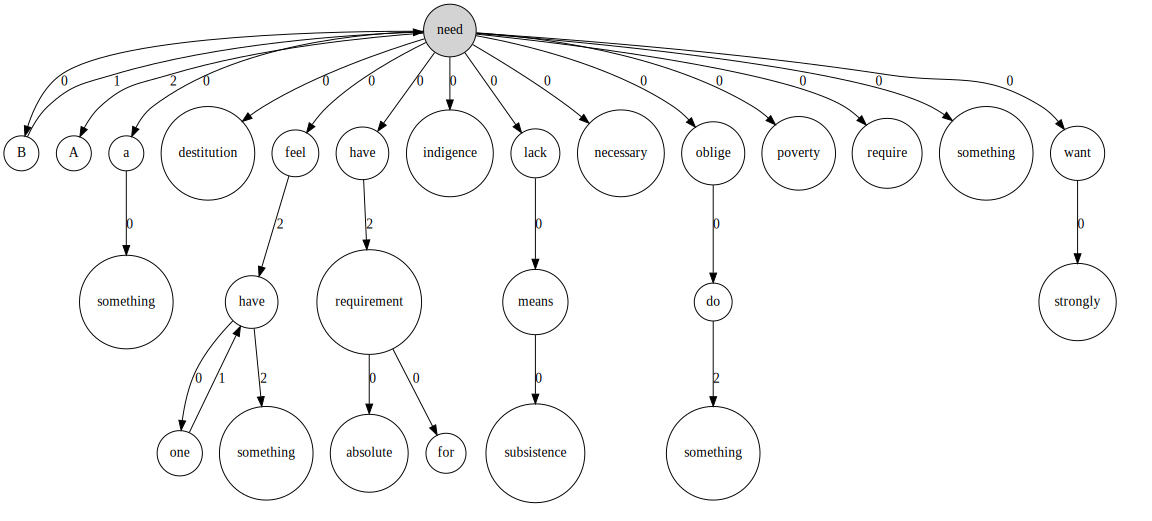

In [28]:
Source(graph_premise.to_dot())

In [29]:
len(graph_hypothesises)

2

In [ ]:
edges = []
for edge in graph_premise.G.edges(data=True):
    X = edge[0]
    Y = edge[1]
    color = edge[2]['color']
    
    nodes_to_append = whitelisting(graph_premise, Y)
    for node in nodes_to_append:
        edges.append((X, node, color))
    nodes_to_append = whitelisting(graph_premise, X)
    for node in nodes_to_append:
        node_edges = graph_premise.G.edges(node, data=True)
        for n in node_edges:
            n_color = n[2]["color"]
            edges.append((X, n[1], n_color))
    

edges = list(set(edges))
edges
#for edge in edges:
#    graph_premise.G.add_edge(edge[0], edge[1], color=edge[2])

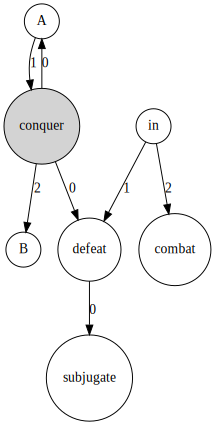

In [69]:
Source(graph_hypothesises[0].to_dot())

In [ ]:
text_to_4lang.get_definition("want")

In [139]:
text_to_4lang.get_longman_definition("exploit")

'to treat someone unfairly by asking them to do things for you, but giving them very little in return - used to show disapproval'

In [59]:
text_to_4lang.get_synsets("force", pos="v")

['coerce', 'hale', 'squeeze', 'pressure']

In [42]:
text_to_4lang.lexicon.wiktionary_synonyms["dog"]

defaultdict(list, {'occupy': [], 'dog': []})

In [62]:
text_to_4lang.lexicon.lexicon_list["invade"]

['To move into.',
 'To enter by force in order to conquer.',
 'To infest or overrun.',
 'To attack; to infringe; to encroach on; to violate.',
 'To make an unwelcome or uninvited visit or appearance, usually with an intent to cause trouble or some other unpleasant situation.']

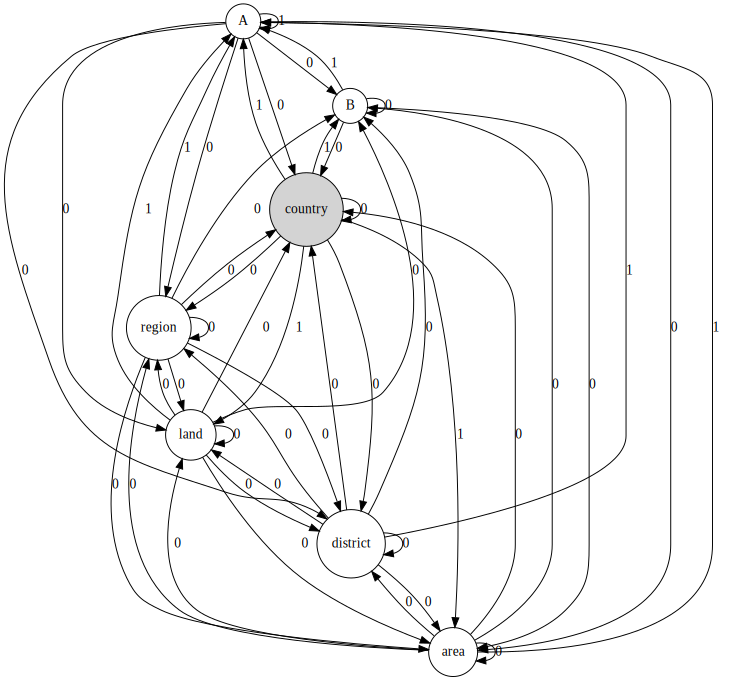

In [16]:
graph_test = text_to_4lang.process_text("A is country in B", method="expand", depth=1, blacklist=["in", "on", "of"], filt=False, black_or_white="black", multi_definition=False, apply_from_depth=2)
g = append_zero_paths(graph_test)
Source(g.to_dot())

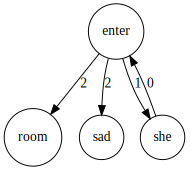

In [50]:
graph_test = text_to_4lang.process_text("She entered the room sad", method="expand", depth=0, blacklist=["in", "on", "of"], filt=False, black_or_white="black", multi_definition=True, apply_from_depth=2)
#append_zero_paths(graph_test)
Source(graph_test.to_dot())

In [ ]:
import pickle
with open("dat/expanded_mulit_irtgs", 'rb') as handle:
    text_to_4lang.lexicon.expanded_with_every_def = pickle.load(handle)

In [ ]:
from itertools import product

l = [[1,2,3], [1,2]]

for combined in product(*l):
    print(combined)

In [53]:
gs = text_to_4lang.get_hypothesis("The centre, essence, or core.")

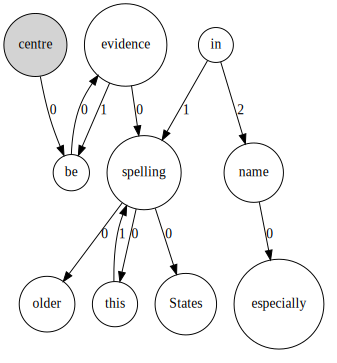

In [54]:
Source(gs[0].to_dot())

In [ ]:
for i in range(0):
    print(i)

In [33]:
"use" in stopwords

False

In [37]:
import stanza

In [38]:
nlp = stanza.Pipeline('en')

2021-01-11 18:32:45 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| sentiment | sstplus   |
| ner       | ontonotes |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-01-11 18:32:45 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2021-01-11 18:32:45 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2021-01-11 18:32:45 INFO: Loading: pos
INFO:stanza:Loading: pos
2021-01-11 18:32:47 INFO: Loading: lemma
INFO:stanza:Loading: lemma
2021-01-11 18:32:47 INFO: Loading: depparse
INFO:stanza:Loading: depparse
2021-01-11 18:32:49 INFO: Loading: sentiment
INFO:stanza:Loading: sentiment
2021-01-11 18:32:51 

In [39]:
sen = nlp("help you find and organize information").sentences[0]

In [41]:
sen.id

AttributeError: 'Sentence' object has no attribute 'id'

In [48]:
sen = nlp("John made two cup of coffee").sentences[0]

In [49]:
sen.print_dependencies()

('John', 2, 'nsubj')
('made', 0, 'root')
('two', 4, 'nummod')
('cup', 2, 'obj')
('of', 6, 'case')
('coffee', 4, 'nmod')


In [35]:
graph_premise = text_to_4lang.process_text("A is interviewing B", method="expand", depth=2, blacklist=["in", "on", "of"], multi_definition=False, black_or_white="black", filt=False, apply_from_depth=1)
graph_hypothesises = text_to_4lang.get_hypothesis("A is asking B")

zero_prem = append_zero_paths(graph_premise)

pred = asim_jac_edges_all(zero_prem, graph_hypothesises)
print(pred)

set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
{('A', 'person', 0), ('person', 'A', 1), ('person', 'B', 2)}
0.6
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
set()
0.0
0.6
